# Combination of feature engineering and downsampling for feature importance--random forest (other vaccine included in features)

In [1]:
import sys
# adding to the path variables the one folder higher (locally, not changing system variables)
sys.path.append("..")
import pandas as pd
import numpy as np
import warnings
import mlflow
from modeling.config import TRACKING_URI, EXPERIMENT_NAME

RSEED = 42
# Modeling Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer

from sklearn.dummy import DummyClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

# for resampling (data balancing)
from sklearn.utils import resample

# for feature importance
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance

warnings.filterwarnings('ignore')



Data import:

In [2]:
df = pd.read_csv('../data/Flu_Shot_Data_cleaned_2.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   26707 non-null  int64  
 1   h1n1_vaccine                 26707 non-null  int64  
 2   seasonal_vaccine             26707 non-null  int64  
 3   h1n1_concern                 26615 non-null  float64
 4   h1n1_knowledge               26591 non-null  float64
 5   behavioral_antiviral_meds    26636 non-null  float64
 6   behavioral_avoidance         26499 non-null  float64
 7   behavioral_face_mask         26688 non-null  float64
 8   behavioral_wash_hands        26665 non-null  float64
 9   behavioral_large_gatherings  26620 non-null  float64
 10  behavioral_outside_home      26625 non-null  float64
 11  behavioral_touch_face        26579 non-null  float64
 12  doctor_recc_h1n1             24547 non-null  float64
 13  doctor_recc_seas

In [4]:
# Getting rid of column 'Unnamed: 0'
df = df.drop('Unnamed: 0', axis=1)

In [5]:
df.census_msa.value_counts()

MSA, Not Principle  City    11645
MSA, Principle City          7864
Non-MSA                      7198
Name: census_msa, dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 37 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_vaccine                 26707 non-null  int64  
 1   seasonal_vaccine             26707 non-null  int64  
 2   h1n1_concern                 26615 non-null  float64
 3   h1n1_knowledge               26591 non-null  float64
 4   behavioral_antiviral_meds    26636 non-null  float64
 5   behavioral_avoidance         26499 non-null  float64
 6   behavioral_face_mask         26688 non-null  float64
 7   behavioral_wash_hands        26665 non-null  float64
 8   behavioral_large_gatherings  26620 non-null  float64
 9   behavioral_outside_home      26625 non-null  float64
 10  behavioral_touch_face        26579 non-null  float64
 11  doctor_recc_h1n1             24547 non-null  float64
 12  doctor_recc_seasonal         24547 non-null  float64
 13  chronic_med_cond

Random forest (without 1-hot encoding) and the permutation importance will not work with:
a.) string as features
b.) missing data (https://datascience.stackexchange.com/questions/72764/can-random-forest-regressor-or-decision-trees-handle-missing-values-and-outliers )

**Filling in missing values**

A dummy value (-999) is used to replace NaN values. Apparently, as long as you use a dummy value that doesn't appear in the feature (such as -999), then the algorithm handles this automatically (https://www.kaggle.com/questions-and-answers/60595; https://www.analyticsvidhya.com/blog/2021/05/dealing-with-missing-values-in-python-a-complete-guide/ ). I have tried comparing this approach to analysis on a notebook that still had Nan values, and the resultant evaluation metrics remain largely the same (with variation of up to 0.02...but that could be due to the use of the random forest classifier)

**Converting string info to numerical**

In [7]:
cleanup = {"age_group": {"18 - 34 Years": 1, "35 - 44 Years": 2, "45 - 54 Years": 3, "55 - 64 Years": 4,
                                  "65+ Years": 5},
            "education": {"< 12 Years": 1, "12 Years": 2, "Some College": 3, "College Graduate": 4},
            "race": {"White": 1, "Black": 2, "Hispanic": 3, "Other or Multiple": 4},
            "sex" : {"Female": 1, "Male": 2},
            "rent_or_own" : {"Own": 1, "Rent": 2},
            "hhs_geo_region" : {"lzgpxyit": 1, "fpwskwrf": 2, "qufhixun": 3, "bhuqouqj": 4, "oxchjgsf": 5, "kbazzjca": 6, "mlyzmhmf": 7, "atmpeygn": 8, "lrircsnp": 9, "dqpwygqj": 10},
            "census_msa" : {"MSA, Principle City": 1, "MSA, Not Principle  City": 2, "Non-MSA": 3},
            "income_poverty" : {"Below Poverty": 1, "<= $75,000, Above Poverty": 2, "> $75,000": 3},
            "employment_industry" : {"fcxhlnwr": 1, "wxleyezf": 2, "ldnlellj": 3, "pxcmvdjn": 4, "atmlpfrs": 5, "arjwrbjb": 6, "xicduogh": 7, "mfikgejo": 8, "vjjrobsf": 9,
                                    "rucpziij": 10, "xqicxuve": 11, "saaquncn": 12, "cfqqtusy": 13, "nduyfdeo": 14, "mcubkhph": 15, "wlfvacwt": 16, "dotnnunm": 17, "haxffmxo": 18, "msuufmds": 19, "phxvnwax": 20,
                                    "qnlwzans": 21},
           "employment_occupation" : {"xtkaffoo": 1, "mxkfnird": 2, "emcorrxb": 3, "cmhcxjea": 4, "xgwztkwe": 5, "hfxkjkmi": 6, "qxajmpny": 7, "xqwwgdyp": 8, "kldqjyjy": 9,
                                    "uqqtjvyb": 10, "tfqavkke": 11, "ukymxvdu": 12, "vlluhbov": 13, "oijqvulv": 14, "ccgxvspp": 15, "bxpfxfdn": 16, "haliazsg": 17, "rcertsgn": 18, "xzmlyyjv": 19, "dlvbwzss": 20,
                                    "hodpvpew": 21, "dcjcmpih": 22, "pvmttkik": 23},
           "marital_status" : {"Married": 1, "Not Married": 2},
           "employment_status" : {"Employed": 1, "Not in Labor Force": 2, "Unemployed": 3}
                                  }

In [8]:
df_num = df.replace(cleanup)

In [9]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 37 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_vaccine                 26707 non-null  int64  
 1   seasonal_vaccine             26707 non-null  int64  
 2   h1n1_concern                 26615 non-null  float64
 3   h1n1_knowledge               26591 non-null  float64
 4   behavioral_antiviral_meds    26636 non-null  float64
 5   behavioral_avoidance         26499 non-null  float64
 6   behavioral_face_mask         26688 non-null  float64
 7   behavioral_wash_hands        26665 non-null  float64
 8   behavioral_large_gatherings  26620 non-null  float64
 9   behavioral_outside_home      26625 non-null  float64
 10  behavioral_touch_face        26579 non-null  float64
 11  doctor_recc_h1n1             24547 non-null  float64
 12  doctor_recc_seasonal         24547 non-null  float64
 13  chronic_med_cond

## Checking feature correlation

In [10]:
# getting the highly correlated features--numerical features, without imputing the dummy value
s = df_num.corr(method='spearman').unstack().sort_values(kind="quicksort", ascending=False).drop_duplicates()
print(s[1:10])

doctor_recc_h1n1             doctor_recc_seasonal           0.591868
behavioral_large_gatherings  behavioral_outside_home        0.584085
opinion_h1n1_risk            opinion_seas_risk              0.564522
opinion_h1n1_sick_from_vacc  opinion_seas_sick_from_vacc    0.502192
opinion_h1n1_vacc_effective  opinion_seas_vacc_effective    0.444043
education                    income_poverty                 0.415926
seasonal_vaccine             opinion_seas_vacc_effective    0.397874
h1n1_vaccine                 doctor_recc_h1n1               0.393890
seasonal_vaccine             opinion_seas_risk              0.389286
dtype: float64


These results are consistent with previous results (feature_engineering notebook)

### Creating a new column based on recommendation (2 binary features)
- applying a function that tells if both, none or either of the vaccines have been recommended

In [11]:
def get_reco(row):
    # none of the vaccines has been recommended
    if row['doctor_recc_seasonal'] == 0 and row['doctor_recc_h1n1'] == 0:
        val = 0
    # both vaccines have been recommended
    elif row['doctor_recc_seasonal'] == 0 and row['doctor_recc_h1n1'] == 1:
        val = 1
    # only seasonal vaccine has been recommended 
    elif row['doctor_recc_seasonal'] == 1 and row['doctor_recc_h1n1'] == 0:
        val = 2
    # only H1N1 vaccine has been recommended
    elif row['doctor_recc_seasonal'] == 1 and row['doctor_recc_h1n1'] == 1:
        val = 3
    else:
        val = None
    return val 

In [12]:
# Applying the function
# values will be converted to categorical 
df_num['reco_vaccines'] = df_num.apply(get_reco, axis=1).astype('category')

In [13]:
df_num['reco_vaccines'].value_counts()

0.0    15659
3.0     4614
2.0     3480
1.0      794
Name: reco_vaccines, dtype: int64

In [14]:
print(df_num.behavioral_large_gatherings.value_counts())
print(df_num.behavioral_outside_home.value_counts())

0.0    17073
1.0     9547
Name: behavioral_large_gatherings, dtype: int64
0.0    17644
1.0     8981
Name: behavioral_outside_home, dtype: int64


### Creating a new column based on 2 behavioural features

- next, we will create a function that combines behaviour at large gatherings and outside of home
- NOTE: we need to make an assumption that '0' refers to not having done it and '1' refers to having done it 

In [15]:
def get_behaviour(row):
    # none of the behaviours applies 
    if row['behavioral_large_gatherings'] == 0 and row['behavioral_outside_home'] == 0:
        val = 0
    # both behaviours apply 
    elif row['behavioral_large_gatherings'] == 0 and row['behavioral_outside_home'] == 1:
        val = 1
    # only reducing time at large gatherings applies 
    elif row['behavioral_large_gatherings'] == 1 and row['behavioral_outside_home'] == 0:
        val = 2
    # only reduced contact with people outside of household applies 
    elif row['behavioral_large_gatherings'] == 1 and row['behavioral_outside_home'] == 1:
        val = 3
    else:
        val = None
    return val 

In [16]:
# Applying the function
# values will be converted to categorical 
df_num['behaviour_gather_home'] = df_num.apply(get_behaviour, axis=1).astype('category')

In [17]:
df_num.behaviour_gather_home.value_counts()

0.0    14808
3.0     6723
2.0     2796
1.0     2224
Name: behaviour_gather_home, dtype: int64

- we will now drop the columns that are no longer necessary 

In [18]:
removal = ['doctor_recc_seasonal', 'doctor_recc_h1n1', 'behavioral_large_gatherings', 'behavioral_outside_home']

df_num.drop(removal, axis=1, inplace=True)

In [19]:
df_num.head(20)

,h1n1_vaccine,seasonal_vaccine,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_touch_face,chronic_med_condition,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,reco_vaccines,behaviour_gather_home
0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,2.0,5,3,0.0,0.0,NaN,NaN,0.0,1.0
1,0,1,3.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,...,2.0,1.0,4,2,0.0,0.0,4.0,5.0,0.0,1.0
2,0,0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,3,2,2.0,0.0,10.0,1.0,NaN,0.0
3,0,1,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,2.0,2.0,9,1,0.0,0.0,NaN,NaN,2.0,2.0
4,0,0,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,1.0,1.0,3,2,1.0,0.0,2.0,3.0,0.0,2.0
5,0,0,3.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,1.0,1.0,8,1,2.0,3.0,12.0,13.0,2.0,0.0
6,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,3,2,0.0,0.0,7.0,1.0,0.0,0.0
7,1,1,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,4,3,2.0,0.0,4.0,8.0,1.0,0.0
8,0,0,0.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,...,1.0,1.0,4,2,1.0,0.0,7.0,15.0,0.0,3.0
9,0,0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,1.0,2.0,3,2,0.0,0.0,NaN,NaN,0.0,2.0


### Removal of feature depending on target

#### Making dataframe for the H1N1 vacc output (seasonal vacc included in features)

Dropping target variable:

In [20]:
X_h1n1 = df_num.drop(columns=['h1n1_vaccine'])

Filling missing values with dummy values:

In [21]:
X_h1n1_cols = X_h1n1.columns

In [22]:
imp_const = SimpleImputer(strategy='constant', fill_value=-999)

In [23]:
X_h1n1 = imp_const.fit_transform(X_h1n1)

In [24]:
X_h1n1 = pd.DataFrame(X_h1n1, columns=X_h1n1_cols)

Feature engineering:  
- apply the following code if H1N1 is the single target variable 
- we take out the feature that is related to seasonal flu/vaccine

In [25]:
list_seas = ['opinion_seas_risk', 'opinion_seas_sick_from_vacc']

X_h1n1.drop(list_seas, axis=1, inplace=True)

#### Making dataframe for the seasonal vacc output (H1N1 vacc included in features)

Dropping target variable:

In [26]:
X_seas = df_num.drop(columns=['seasonal_vaccine'])

Filling missing values with dummy values:

In [27]:
X_seas_cols = X_seas.columns

In [28]:
imp_const = SimpleImputer(strategy='constant', fill_value=-999)

In [29]:
X_seas = imp_const.fit_transform(X_seas)

In [30]:
X_seas = pd.DataFrame(X_seas, columns=X_seas_cols)

Feature engineering:
- apply the following code if seasonal vaccine is the single target variable 
- we take out the feature that is related to H1N1 flu/vaccine

In [31]:
list_h1n1 = ['opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc']

X_seas.drop(list_h1n1, axis=1, inplace=True)

# Prediction of H1N1 vaccination (seasonal vaccine in features)

Setting up target variable:

In [32]:
y_h1n1 = df_num['h1n1_vaccine']
#y_h1n1 = y_h1n1.to_numpy()
y_h1n1

0        0
1        0
2        0
3        0
4        0
        ..
26702    0
26703    0
26704    0
26705    0
26706    0
Name: h1n1_vaccine, Length: 26707, dtype: int64

Performing the test-train split:

In [33]:
X_h1n1_train, X_h1n1_test, y_h1n1_train, y_h1n1_test = train_test_split(X_h1n1, y_h1n1, stratify = y_h1n1, test_size=0.2, random_state=RSEED)

In [34]:
print('X_h1n1_train shape:', X_h1n1_train.shape)
print('X_h1n1_test shape:', X_h1n1_test.shape)
print('y_h1n1_train:', y_h1n1_train.shape)
print('y_h1n1_test:', y_h1n1_test.shape)

X_h1n1_train shape: (21365, 32)
X_h1n1_test shape: (5342, 32)
y_h1n1_train: (21365,)
y_h1n1_test: (5342,)


## Downsampling (Undersampling of the majority class (h1n1_vaccine == 0))

https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18

**Creating concatenated training dataframe and separating into minority and majority class (for data balancing)**

In [35]:
# concatenating our train data back together

concat_train_df = pd.concat([X_h1n1_train, y_h1n1_train], axis = 1)

# separating into minority and majority classes

# majority class
no_h1n1_vacc = concat_train_df[concat_train_df.h1n1_vaccine==0]

# minority class
yes_h1n1_vacc = concat_train_df[concat_train_df.h1n1_vaccine==1]

**Undersampling of majority class (downsampling)**

In [36]:
# downsample minority class
no_h1n1_vacc_downsampled = resample(no_h1n1_vacc,
                                   replace = False,
                                   n_samples = len(yes_h1n1_vacc),
                                   random_state = RSEED)

In [37]:
# combine minority and downsampled majority

downsampled = pd.concat([no_h1n1_vacc_downsampled, yes_h1n1_vacc])

In [38]:
# checking new class counts
downsampled.h1n1_vaccine.value_counts()

0    4539
1    4539
Name: h1n1_vaccine, dtype: int64

In [39]:
# relabelling the downsampled data as train dataset

y_h1n1_downsamp_train = downsampled[['h1n1_vaccine']]

X_downsamp_train =downsampled.drop(['h1n1_vaccine'], axis = 1)

Making the predictor varaible into a flattened array:

In [40]:
y_h1n1_downsamp_train = y_h1n1_downsamp_train.to_numpy()
y_h1n1_downsamp_train = y_h1n1_downsamp_train.ravel()

In [41]:
y_h1n1_downsamp_train

array([0, 0, 0, ..., 1, 1, 1])

In [42]:
y_h1n1_test = y_h1n1_test.to_numpy()

In [43]:
y_h1n1_test

array([1, 1, 0, ..., 1, 0, 0])

## Modelling and prediction (RFC only)

Instantiate the model:

In [44]:
rand_forst= RandomForestClassifier()

Fitting the model:

In [45]:
h1n1_rand_forst_model = rand_forst.fit(X_downsamp_train, y_h1n1_downsamp_train)

Making predictions:

In [46]:
rand_forst_trainpreds = h1n1_rand_forst_model.predict(X_h1n1_train)
rand_forst_testpreds = h1n1_rand_forst_model.predict(X_h1n1_test)

## Model evaluation (RFC only)

Train data

In [47]:
# Random Forest--Train data evaluation Metrics
#check if these metrics are changing compared to previous results
h1n1_rand_forst_train_acc = accuracy_score(y_h1n1_train, rand_forst_trainpreds)
h1n1_rand_forst_train_recall = recall_score(y_h1n1_train, rand_forst_trainpreds)
h1n1_rand_forst_train_precision = precision_score(y_h1n1_train, rand_forst_trainpreds)
h1n1_rand_forst_train_f1 = f1_score(y_h1n1_train, rand_forst_trainpreds)
h1n1_rand_forst_train_roc = roc_auc_score(y_h1n1_train, rand_forst_trainpreds)

print("Accuracy: {:.2f}".format(h1n1_rand_forst_train_acc))
print("Recall: {:.2f}".format(h1n1_rand_forst_train_recall))
print("Precision: {:.2f}".format(h1n1_rand_forst_train_precision))
print("F1: {:.2f}".format(h1n1_rand_forst_train_f1))
print("ROC: {:.2f}".format(h1n1_rand_forst_train_roc))

Accuracy: 0.90
Recall: 1.00
Precision: 0.67
F1: 0.81
ROC: 0.93


Test data

In [48]:
# Random Forest--Test data evaluation Metrics
#check if these metrics are changing compared to previous results
h1n1_rand_forst_test_acc = accuracy_score(y_h1n1_test, rand_forst_testpreds)
h1n1_rand_forst_test_recall = recall_score(y_h1n1_test, rand_forst_testpreds)
h1n1_rand_forst_test_precision = precision_score(y_h1n1_test, rand_forst_testpreds)
h1n1_rand_forst_test_f1 = f1_score(y_h1n1_test, rand_forst_testpreds)
h1n1_rand_forst_test_roc = roc_auc_score(y_h1n1_test, rand_forst_testpreds)

print("Accuracy: {:.2f}".format(h1n1_rand_forst_test_acc))
print("Recall: {:.2f}".format(h1n1_rand_forst_test_recall))
print("Precision: {:.2f}".format(h1n1_rand_forst_test_precision))
print("F1: {:.2f}".format(h1n1_rand_forst_test_f1))
print("ROC: {:.2f}".format(h1n1_rand_forst_test_roc))

Accuracy: 0.81
Recall: 0.79
Precision: 0.53
F1: 0.63
ROC: 0.80


## Error evaluation of model

**Confusion matrix**

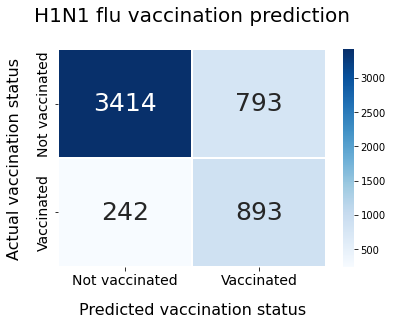

In [49]:
cm = confusion_matrix(y_h1n1_test, rand_forst_testpreds)
sns.heatmap(cm, cmap='Blues', annot=True, fmt='d', linewidths=.5, annot_kws={"size":25})
plt.title("H1N1 flu vaccination prediction", fontsize=20, y=1.1)
plt.ylabel('Actual vaccination status', fontsize=16)
plt.xlabel('Predicted vaccination status', fontsize=16)
labels = ['Not vaccinated', 'Vaccinated']
ax = plt.gca()
ax.set_xticklabels(labels, fontsize=14)
ax.set_yticklabels(labels, va="center", fontsize=14)
ax.yaxis.labelpad = 15
ax.xaxis.labelpad = 15

**ROC curve**

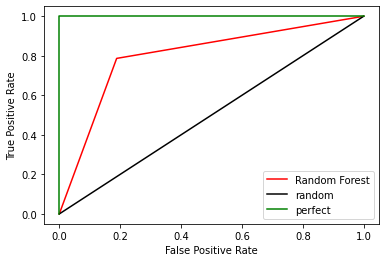

AUC Random Forest:0.799


In [50]:
fpr_rand_forst, tpr_rand_forst, thresholds_rand_forst = metrics.roc_curve(y_h1n1_test, rand_forst_testpreds)

plt.plot(fpr_rand_forst, tpr_rand_forst,'r-',label = 'Random Forest')
plt.plot([0,1],[0,1],'k-',label='random')
plt.plot([0,0,1,1],[0,1,1,1],'g-',label='perfect')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

auc_rand_forst = roc_auc_score(y_h1n1_test, rand_forst_testpreds)
print('AUC Random Forest:%.3f'% auc_rand_forst)

## Setting up the Grid Search for hyperparameter tuning

In [63]:
h1n1_rand_forst_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [67]:
h1n1_rand_forst_model.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [68]:
# will need to be adjusted in further runs 
# the pipeline step is accessed with 'estimators__estimator__'

param_grid_unilabel = {
    'n_estimators': np.linspace(10, 100, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    #'estimators__estimator__min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

In [69]:
# the random search model is created 
# we define roc_auc as our evaluation metric for the parameter search 
# set verbose to a higher number next time 

grid_rand_forst_unilabel = RandomizedSearchCV(h1n1_rand_forst_model, param_distributions=param_grid_unilabel, cv=5, scoring='roc_auc', verbose=50, n_jobs=-1, n_iter=100)

## Fitting the grid search to our model

In [70]:
rand_forst_unilabel = grid_rand_forst_unilabel.fit(X_downsamp_train, y_h1n1_downsamp_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 5/5; 1/100] START bootstrap=False, max_depth=17, max_features=auto, max_leaf_nodes=32, n_estimators=22
[CV 5/5; 1/100] END bootstrap=False, max_depth=17, max_features=auto, max_leaf_nodes=32, n_estimators=22;, score=0.872 total time=   0.2s
[CV 2/5; 3/100] START bootstrap=False, max_depth=17, max_features=None, max_leaf_nodes=15, n_estimators=78
[CV 2/5; 3/100] END bootstrap=False, max_depth=17, max_features=None, max_leaf_nodes=15, n_estimators=78;, score=0.871 total time=   2.2s
[CV 2/5; 6/100] START bootstrap=False, max_depth=13, max_features=0.7, max_leaf_nodes=28, n_estimators=58
[CV 2/5; 6/100] END bootstrap=False, max_depth=13, max_features=0.7, max_leaf_nodes=28, n_estimators=58;, score=0.889 total time=   1.6s
[CV 5/5; 7/100] START bootstrap=True, max_depth=4, max_features=0.5, max_leaf_nodes=25, n_estimators=97
[CV 5/5; 7/100] END bootstrap=True, max_depth=4, max_features=0.5, max_leaf_nodes=25, n_estimators=9

In [71]:
# Show best parameters
print('Best score:\n{:.2f}'.format(rand_forst_unilabel.best_score_))
print("Best parameters:\n{}".format(rand_forst_unilabel.best_params_))

Best score:
0.89
Best parameters:
{'n_estimators': 52, 'max_leaf_nodes': 48, 'max_features': 0.5, 'max_depth': 8, 'bootstrap': False}


In [73]:
# Save best model

best_model_rand_forst_unilabel = rand_forst_unilabel.best_estimator_

In [75]:
# Make predictions using the best model

best_model_h1n1_train = best_model_rand_forst_unilabel.predict(X_h1n1_train)

best_model_h1n1_test = best_model_rand_forst_unilabel.predict(X_h1n1_test)

In [78]:
best_model_h1n1_test.sum()

1733

In [79]:
best_model_h1n1_train.sum()

6869

In [80]:
y_h1n1_train.sum()

4539

## Setting up the Grid Search for hyperparameter tuning

In [63]:
h1n1_rand_forst_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [67]:
h1n1_rand_forst_model.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [68]:
# will need to be adjusted in further runs 
# the pipeline step is accessed with 'estimators__estimator__'

param_grid_unilabel = {
    'n_estimators': np.linspace(10, 100, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    #'estimators__estimator__min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

In [69]:
# the random search model is created 
# we define roc_auc as our evaluation metric for the parameter search 
# set verbose to a higher number next time 

grid_rand_forst_unilabel = RandomizedSearchCV(h1n1_rand_forst_model, param_distributions=param_grid_unilabel, cv=5, scoring='roc_auc', verbose=50, n_jobs=-1, n_iter=100)

## Fitting the grid search to our model

In [70]:
rand_forst_unilabel = grid_rand_forst_unilabel.fit(X_downsamp_train, y_h1n1_downsamp_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 5/5; 1/100] START bootstrap=False, max_depth=17, max_features=auto, max_leaf_nodes=32, n_estimators=22
[CV 5/5; 1/100] END bootstrap=False, max_depth=17, max_features=auto, max_leaf_nodes=32, n_estimators=22;, score=0.872 total time=   0.2s
[CV 2/5; 3/100] START bootstrap=False, max_depth=17, max_features=None, max_leaf_nodes=15, n_estimators=78
[CV 2/5; 3/100] END bootstrap=False, max_depth=17, max_features=None, max_leaf_nodes=15, n_estimators=78;, score=0.871 total time=   2.2s
[CV 2/5; 6/100] START bootstrap=False, max_depth=13, max_features=0.7, max_leaf_nodes=28, n_estimators=58
[CV 2/5; 6/100] END bootstrap=False, max_depth=13, max_features=0.7, max_leaf_nodes=28, n_estimators=58;, score=0.889 total time=   1.6s
[CV 5/5; 7/100] START bootstrap=True, max_depth=4, max_features=0.5, max_leaf_nodes=25, n_estimators=97
[CV 5/5; 7/100] END bootstrap=True, max_depth=4, max_features=0.5, max_leaf_nodes=25, n_estimators=9

In [71]:
# Show best parameters
print('Best score:\n{:.2f}'.format(rand_forst_unilabel.best_score_))
print("Best parameters:\n{}".format(rand_forst_unilabel.best_params_))

Best score:
0.89
Best parameters:
{'n_estimators': 52, 'max_leaf_nodes': 48, 'max_features': 0.5, 'max_depth': 8, 'bootstrap': False}


In [73]:
# Save best model

#best_model_rand_forst_unilabel = rand_forst_unilabel.best_estimator_

In [104]:
# running model manually using the best hyperparameters

best_model_rand_forst_unilabel= RandomForestClassifier(n_estimators= 52, max_leaf_nodes=48, max_features=0.5, max_depth=8, bootstrap=False)

In [105]:
best_model_rand_forst_unilabel = best_model_rand_forst_unilabel.fit(X_downsamp_train, y_h1n1_downsamp_train)

In [106]:
# Make predictions using the best model

best_model_h1n1_train = best_model_rand_forst_unilabel.predict(X_h1n1_train)

best_model_h1n1_test = best_model_rand_forst_unilabel.predict(X_h1n1_test)

## Best model evaluation (RFC, hyperparameter turned)

Train data

In [107]:
# Random Forest--Train data evaluation Metrics
#check if these metrics are changing compared to previous results
h1n1_best_train_acc = accuracy_score(y_h1n1_train, best_model_h1n1_train)
h1n1_best_train_recall = recall_score(y_h1n1_train, best_model_h1n1_train)
h1n1_best_train_precision = precision_score(y_h1n1_train, best_model_h1n1_train)
h1n1_best_train_f1 = f1_score(y_h1n1_train, best_model_h1n1_train)
h1n1_best_train_roc = roc_auc_score(y_h1n1_train, best_model_h1n1_train)

print("Accuracy: {:.2f}".format(h1n1_best_train_acc))
print("Recall: {:.2f}".format(h1n1_best_train_recall))
print("Precision: {:.2f}".format(h1n1_best_train_precision))
print("F1: {:.2f}".format(h1n1_best_train_f1))
print("ROC: {:.2f}".format(h1n1_best_train_roc))

Accuracy: 0.82
Recall: 0.83
Precision: 0.54
F1: 0.66
ROC: 0.82


Test data

In [108]:
# Random Forest--Test data evaluation Metrics
#check if these metrics are changing compared to previous results
h1n1_best_test_acc = accuracy_score(y_h1n1_test, best_model_h1n1_test)
h1n1_best_test_recall = recall_score(y_h1n1_test, best_model_h1n1_test)
h1n1_best_test_precision = precision_score(y_h1n1_test, best_model_h1n1_test)
h1n1_best_test_f1 = f1_score(y_h1n1_test, best_model_h1n1_test)
h1n1_best_test_roc = roc_auc_score(y_h1n1_test, best_model_h1n1_test)

print("Accuracy: {:.2f}".format(h1n1_best_test_acc))
print("Recall: {:.2f}".format(h1n1_best_test_recall))
print("Precision: {:.2f}".format(h1n1_best_test_precision))
print("F1: {:.2f}".format(h1n1_best_test_f1))
print("ROC: {:.2f}".format(h1n1_best_test_roc))

Accuracy: 0.81
Recall: 0.81
Precision: 0.53
F1: 0.64
ROC: 0.81


## Error evaluation of model (after hyperparameter tuning)

**Confusion matrix**

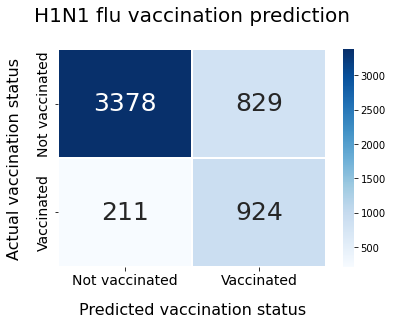

In [109]:
cm = confusion_matrix(y_h1n1_test, best_model_h1n1_test)
sns.heatmap(cm, cmap='Blues', annot=True, fmt='d', linewidths=.5, annot_kws={"size":25})
plt.title("H1N1 flu vaccination prediction", fontsize=20, y=1.1)
plt.ylabel('Actual vaccination status', fontsize=16)
plt.xlabel('Predicted vaccination status', fontsize=16)
labels = ['Not vaccinated', 'Vaccinated']
ax = plt.gca()
ax.set_xticklabels(labels, fontsize=14)
ax.set_yticklabels(labels, va="center", fontsize=14)
ax.yaxis.labelpad = 15
ax.xaxis.labelpad = 15

**ROC curve**

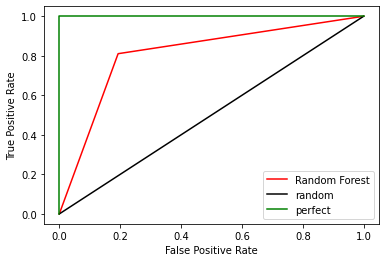

AUC Random Forest:0.809


In [84]:
fpr_rand_forst, tpr_rand_forst, thresholds_rand_forst = metrics.roc_curve(y_h1n1_test, best_model_h1n1_test)

plt.plot(fpr_rand_forst, tpr_rand_forst,'r-',label = 'Random Forest')
plt.plot([0,1],[0,1],'k-',label='random')
plt.plot([0,0,1,1],[0,1,1,1],'g-',label='perfect')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

auc_rand_forst = roc_auc_score(y_h1n1_test, best_model_h1n1_test)
print('AUC Random Forest:%.3f'% auc_rand_forst)

## Best model evaluation (RFC, hyperparameter turned)

Train data

In [81]:
# Random Forest--Train data evaluation Metrics
#check if these metrics are changing compared to previous results
h1n1_best_train_acc = accuracy_score(y_h1n1_train, best_model_h1n1_train)
h1n1_best_train_recall = recall_score(y_h1n1_train, best_model_h1n1_train)
h1n1_best_train_precision = precision_score(y_h1n1_train, best_model_h1n1_train)
h1n1_best_train_f1 = f1_score(y_h1n1_train, best_model_h1n1_train)
h1n1_best_train_roc = roc_auc_score(y_h1n1_train, best_model_h1n1_train)

print("Accuracy: {:.2f}".format(h1n1_best_train_acc))
print("Recall: {:.2f}".format(h1n1_best_train_recall))
print("Precision: {:.2f}".format(h1n1_best_train_precision))
print("F1: {:.2f}".format(h1n1_best_train_f1))
print("ROC: {:.2f}".format(h1n1_best_train_roc))

Accuracy: 0.82
Recall: 0.83
Precision: 0.55
F1: 0.66
ROC: 0.82


Test data

In [82]:
# Random Forest--Test data evaluation Metrics
#check if these metrics are changing compared to previous results
h1n1_best_test_acc = accuracy_score(y_h1n1_test, best_model_h1n1_test)
h1n1_best_test_recall = recall_score(y_h1n1_test, best_model_h1n1_test)
h1n1_best_test_precision = precision_score(y_h1n1_test, best_model_h1n1_test)
h1n1_best_test_f1 = f1_score(y_h1n1_test, best_model_h1n1_test)
h1n1_best_test_roc = roc_auc_score(y_h1n1_test, best_model_h1n1_test)

print("Accuracy: {:.2f}".format(h1n1_best_test_acc))
print("Recall: {:.2f}".format(h1n1_best_test_recall))
print("Precision: {:.2f}".format(h1n1_best_test_precision))
print("F1: {:.2f}".format(h1n1_best_test_f1))
print("ROC: {:.2f}".format(h1n1_best_test_roc))

Accuracy: 0.81
Recall: 0.81
Precision: 0.53
F1: 0.64
ROC: 0.81


## Error evaluation of model (after hyperparameter tuning)

**Confusion matrix**

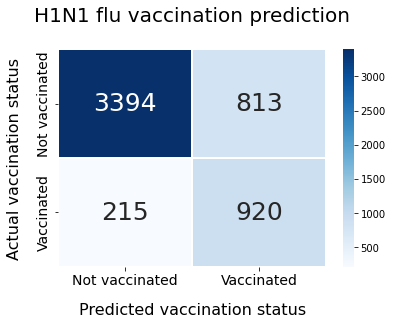

In [83]:
cm = confusion_matrix(y_h1n1_test, best_model_h1n1_test)
sns.heatmap(cm, cmap='Blues', annot=True, fmt='d', linewidths=.5, annot_kws={"size":25})
plt.title("H1N1 flu vaccination prediction", fontsize=20, y=1.1)
plt.ylabel('Actual vaccination status', fontsize=16)
plt.xlabel('Predicted vaccination status', fontsize=16)
labels = ['Not vaccinated', 'Vaccinated']
ax = plt.gca()
ax.set_xticklabels(labels, fontsize=14)
ax.set_yticklabels(labels, va="center", fontsize=14)
ax.yaxis.labelpad = 15
ax.xaxis.labelpad = 15

**ROC curve**

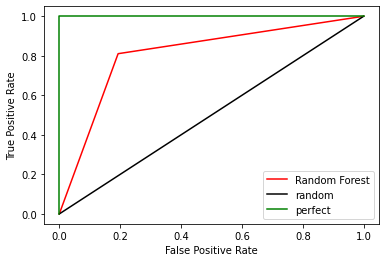

AUC Random Forest:0.809


In [84]:
fpr_rand_forst, tpr_rand_forst, thresholds_rand_forst = metrics.roc_curve(y_h1n1_test, best_model_h1n1_test)

plt.plot(fpr_rand_forst, tpr_rand_forst,'r-',label = 'Random Forest')
plt.plot([0,1],[0,1],'k-',label='random')
plt.plot([0,0,1,1],[0,1,1,1],'g-',label='perfect')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

auc_rand_forst = roc_auc_score(y_h1n1_test, best_model_h1n1_test)
print('AUC Random Forest:%.3f'% auc_rand_forst)

# Prediction of seasonal flu vaccination (H1N1 vaccine in features)

Setting up target variable:

In [51]:
y_seas = df_num['seasonal_vaccine']
y_seas = y_seas.to_numpy()
y_seas

array([0, 1, 0, ..., 1, 0, 0])

Performing the test-train split:

In [52]:
X_seas_train, X_seas_test, y_seas_train, y_seas_test = train_test_split(X_seas, y_seas, stratify = y_seas, test_size=0.2, random_state=RSEED)

In [53]:
print('X_seas_train shape:', X_seas_train.shape)
print('X_seas_test shape:', X_seas_test.shape)
print('y_seas_train:', y_seas_train.shape)
print('y_seas_test:', y_seas_test.shape)

X_seas_train shape: (21365, 32)
X_seas_test shape: (5342, 32)
y_seas_train: (21365,)
y_seas_test: (5342,)


## Modelling and prediction (RFC only)

Instantiate the model:

In [54]:
rand_forst= RandomForestClassifier()

Fitting the model:

In [55]:
seas_rand_forst_model = rand_forst.fit(X_seas_train, y_seas_train)

Making predictions:

In [56]:
seas_rand_forst_trainpreds = seas_rand_forst_model.predict(X_seas_train)
seas_rand_forst_testpreds = seas_rand_forst_model.predict(X_seas_test)

## Model evaluation (RFC only)

Train data

In [57]:
# Random Forest--Train data evaluation Metrics
#check if these metrics are changing compared to previous results
seas_rand_forst_train_acc = accuracy_score(y_seas_train, seas_rand_forst_trainpreds)
seas_rand_forst_train_recall = recall_score(y_seas_train, seas_rand_forst_trainpreds)
seas_rand_forst_train_precision = precision_score(y_seas_train, seas_rand_forst_trainpreds)
seas_rand_forst_train_f1 = f1_score(y_seas_train, seas_rand_forst_trainpreds)
seas_rand_forst_train_roc = roc_auc_score(y_seas_train, seas_rand_forst_trainpreds)

print("Accuracy: {:.2f}".format(seas_rand_forst_train_acc))
print("Recall: {:.2f}".format(seas_rand_forst_train_recall))
print("Precision: {:.2f}".format(seas_rand_forst_train_precision))
print("F1: {:.2f}".format(seas_rand_forst_train_f1))
print("ROC: {:.2f}".format(seas_rand_forst_train_roc))

Accuracy: 1.00
Recall: 1.00
Precision: 1.00
F1: 1.00
ROC: 1.00


Test data

In [58]:
# Random Forest--Test data evaluation Metrics
#check if these metrics are changing compared to previous results
seas_rand_forst_test_acc = accuracy_score(y_seas_test, seas_rand_forst_testpreds)
seas_rand_forst_test_recall = recall_score(y_seas_test, seas_rand_forst_testpreds)
seas_rand_forst_test_precision = precision_score(y_seas_test, seas_rand_forst_testpreds)
seas_rand_forst_test_f1 = f1_score(y_seas_test, seas_rand_forst_testpreds)
seas_rand_forst_test_roc = roc_auc_score(y_seas_test, seas_rand_forst_testpreds)

print("Accuracy: {:.2f}".format(seas_rand_forst_test_acc))
print("Recall: {:.2f}".format(seas_rand_forst_test_recall))
print("Precision: {:.2f}".format(seas_rand_forst_test_precision))
print("F1: {:.2f}".format(seas_rand_forst_test_f1))
print("ROC: {:.2f}".format(seas_rand_forst_test_roc))

Accuracy: 0.80
Recall: 0.76
Precision: 0.80
F1: 0.78
ROC: 0.80


## Error evaluation of model

**Confusion matrix**

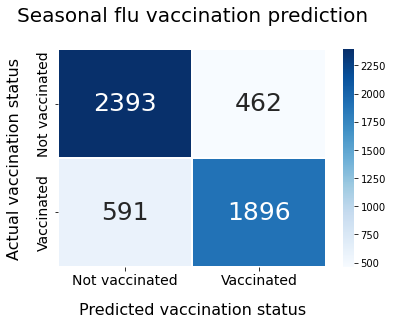

In [59]:
cm = confusion_matrix(y_seas_test, seas_rand_forst_testpreds)
sns.heatmap(cm, cmap='Blues', annot=True, fmt='d', linewidths=.5, annot_kws={"size":25})
plt.title("Seasonal flu vaccination prediction", fontsize=20, y=1.1)
plt.ylabel('Actual vaccination status', fontsize=16)
plt.xlabel('Predicted vaccination status', fontsize=16)
labels = ['Not vaccinated', 'Vaccinated']
ax = plt.gca()
ax.set_xticklabels(labels, fontsize=14)
ax.set_yticklabels(labels, va="center", fontsize=14)
ax.yaxis.labelpad = 15
ax.xaxis.labelpad = 15

**ROC curve**

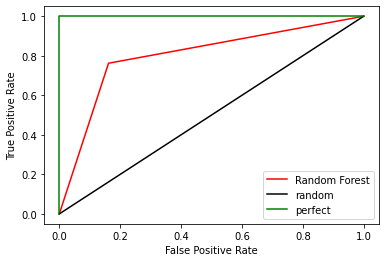

AUC Random Forest:0.799


In [60]:
fpr_rand_forst, tpr_rand_forst, thresholds_rand_forst = metrics.roc_curve(y_seas_test, seas_rand_forst_testpreds)

plt.plot(fpr_rand_forst, tpr_rand_forst,'r-',label = 'Random Forest')
plt.plot([0,1],[0,1],'k-',label='random')
plt.plot([0,0,1,1],[0,1,1,1],'g-',label='perfect')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

auc_rand_forst = roc_auc_score(y_h1n1_test, rand_forst_testpreds)
print('AUC Random Forest:%.3f'% auc_rand_forst)

In [61]:
df.isnull().sum().sum()

60762

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 37 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_vaccine                 26707 non-null  int64  
 1   seasonal_vaccine             26707 non-null  int64  
 2   h1n1_concern                 26615 non-null  float64
 3   h1n1_knowledge               26591 non-null  float64
 4   behavioral_antiviral_meds    26636 non-null  float64
 5   behavioral_avoidance         26499 non-null  float64
 6   behavioral_face_mask         26688 non-null  float64
 7   behavioral_wash_hands        26665 non-null  float64
 8   behavioral_large_gatherings  26620 non-null  float64
 9   behavioral_outside_home      26625 non-null  float64
 10  behavioral_touch_face        26579 non-null  float64
 11  doctor_recc_h1n1             24547 non-null  float64
 12  doctor_recc_seasonal         24547 non-null  float64
 13  chronic_med_cond

## Setting up the Grid Search for hyperparameter tuning

In [85]:
seas_rand_forst_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [86]:
seas_rand_forst_model.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [87]:
# will need to be adjusted in further runs 
# the pipeline step is accessed with 'estimators__estimator__'

param_grid_unilabel = {
    'n_estimators': np.linspace(10, 100, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    #'estimators__estimator__min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

In [88]:
# the random search model is created 
# we define roc_auc as our evaluation metric for the parameter search 
# set verbose to a higher number next time 

seas_grid_rand_forst_unilabel = RandomizedSearchCV(seas_rand_forst_model, param_distributions=param_grid_unilabel, cv=5, scoring='roc_auc', verbose=50, n_jobs=-1, n_iter=100)

## Fitting the grid search to our model

In [89]:
seas_rand_forst_unilabel = seas_grid_rand_forst_unilabel.fit(X_seas_train, y_seas_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 3/5; 1/100] START bootstrap=True, max_depth=16, max_features=0.7, max_leaf_nodes=24, n_estimators=46
[CV 3/5; 1/100] END bootstrap=True, max_depth=16, max_features=0.7, max_leaf_nodes=24, n_estimators=46;, score=0.864 total time=   2.1s
[CV 5/5; 3/100] START bootstrap=True, max_depth=10, max_features=0.7, max_leaf_nodes=49, n_estimators=66
[CV 5/5; 3/100] END bootstrap=True, max_depth=10, max_features=0.7, max_leaf_nodes=49, n_estimators=66;, score=0.872 total time=   4.0s
[CV 2/5; 6/100] START bootstrap=True, max_depth=18, max_features=auto, max_leaf_nodes=35, n_estimators=92
[CV 2/5; 6/100] END bootstrap=True, max_depth=18, max_features=auto, max_leaf_nodes=35, n_estimators=92;, score=0.862 total time=   2.0s
[CV 5/5; 7/100] START bootstrap=True, max_depth=7, max_features=0.7, max_leaf_nodes=29, n_estimators=13
[CV 5/5; 7/100] END bootstrap=True, max_depth=7, max_features=0.7, max_leaf_nodes=29, n_estimators=13;, scor

In [90]:
# Show best parameters
print('Best score:\n{:.2f}'.format(seas_rand_forst_unilabel.best_score_))
print("Best parameters:\n{}".format(seas_rand_forst_unilabel.best_params_))

Best score:
0.87
Best parameters:
{'n_estimators': 66, 'max_leaf_nodes': 49, 'max_features': 0.7, 'max_depth': 10, 'bootstrap': True}


In [96]:
# running model manually using the best hyperparameters

best_rand_forst= RandomForestClassifier(n_estimators= 66, max_leaf_nodes=49, max_features=0.7, max_depth=10, bootstrap=True)

In [98]:
best_rand_forst_model = best_rand_forst.fit(X_seas_train, y_seas_train)

In [91]:
# Save best model

#best_seas_model_rand_forst_unilabel = seas_rand_forst_unilabel.best_estimator_

In [99]:
# Make predictions using the best model

best_model_seas_train = best_rand_forst_model.predict(X_seas_train)

best_model_seas_test = best_rand_forst_model.predict(X_seas_test)

## Best model evaluation (RFC, hyperparameter turned)

Train data

In [100]:
# Random Forest--Train data evaluation Metrics
#check if these metrics are changing compared to previous results
seas_best_train_acc = accuracy_score(y_seas_train, best_model_seas_train)
seas_best_train_recall = recall_score(y_seas_train, best_model_seas_train)
seas_best_train_precision = precision_score(y_seas_train, best_model_seas_train)
seas_best_train_f1 = f1_score(y_seas_train, best_model_seas_train)
seas_best_train_roc = roc_auc_score(y_seas_train, best_model_seas_train)

print("Accuracy: {:.2f}".format(seas_best_train_acc))
print("Recall: {:.2f}".format(seas_best_train_recall))
print("Precision: {:.2f}".format(seas_best_train_precision))
print("F1: {:.2f}".format(seas_best_train_f1))
print("ROC: {:.2f}".format(seas_best_train_roc))

Accuracy: 0.80
Recall: 0.77
Precision: 0.80
F1: 0.78
ROC: 0.80


Test data

In [101]:
# Random Forest--Test data evaluation Metrics
#check if these metrics are changing compared to previous results
seas_best_test_acc = accuracy_score(y_seas_test, best_model_seas_test)
seas_best_test_recall = recall_score(y_seas_test, best_model_seas_test)
seas_best_test_precision = precision_score(y_seas_test, best_model_seas_test)
seas_best_test_f1 = f1_score(y_seas_test, best_model_seas_test)
seas_best_test_roc = roc_auc_score(y_seas_test, best_model_seas_test)

print("Accuracy: {:.2f}".format(seas_best_test_acc))
print("Recall: {:.2f}".format(seas_best_test_recall))
print("Precision: {:.2f}".format(seas_best_test_precision))
print("F1: {:.2f}".format(seas_best_test_f1))
print("ROC: {:.2f}".format(seas_best_test_roc))

Accuracy: 0.79
Recall: 0.75
Precision: 0.80
F1: 0.77
ROC: 0.79


## Error evaluation of model (after hyperparameter tuning)

**Confusion matrix**

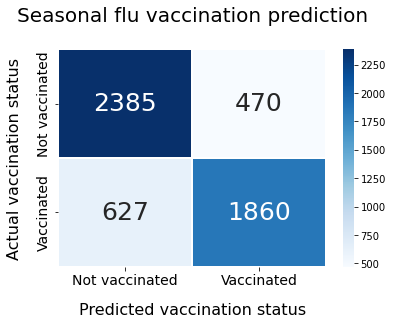

In [102]:
cm = confusion_matrix(y_seas_test, best_model_seas_test)
sns.heatmap(cm, cmap='Blues', annot=True, fmt='d', linewidths=.5, annot_kws={"size":25})
plt.title("Seasonal flu vaccination prediction", fontsize=20, y=1.1)
plt.ylabel('Actual vaccination status', fontsize=16)
plt.xlabel('Predicted vaccination status', fontsize=16)
labels = ['Not vaccinated', 'Vaccinated']
ax = plt.gca()
ax.set_xticklabels(labels, fontsize=14)
ax.set_yticklabels(labels, va="center", fontsize=14)
ax.yaxis.labelpad = 15
ax.xaxis.labelpad = 15

**ROC curve**

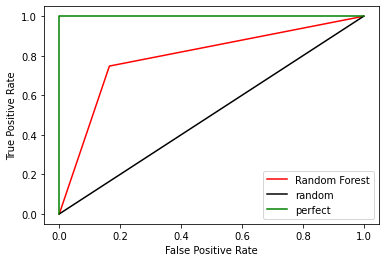

AUC Random Forest:0.792


In [103]:
fpr_rand_forst, tpr_rand_forst, thresholds_rand_forst = metrics.roc_curve(y_seas_test, best_model_seas_test)

plt.plot(fpr_rand_forst, tpr_rand_forst,'r-',label = 'Random Forest')
plt.plot([0,1],[0,1],'k-',label='random')
plt.plot([0,0,1,1],[0,1,1,1],'g-',label='perfect')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

auc_rand_forst = roc_auc_score(y_seas_test, best_model_seas_test)
print('AUC Random Forest:%.3f'% auc_rand_forst)